In [2]:
import pandas as np
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd

[*********************100%%**********************]  2 of 2 completed


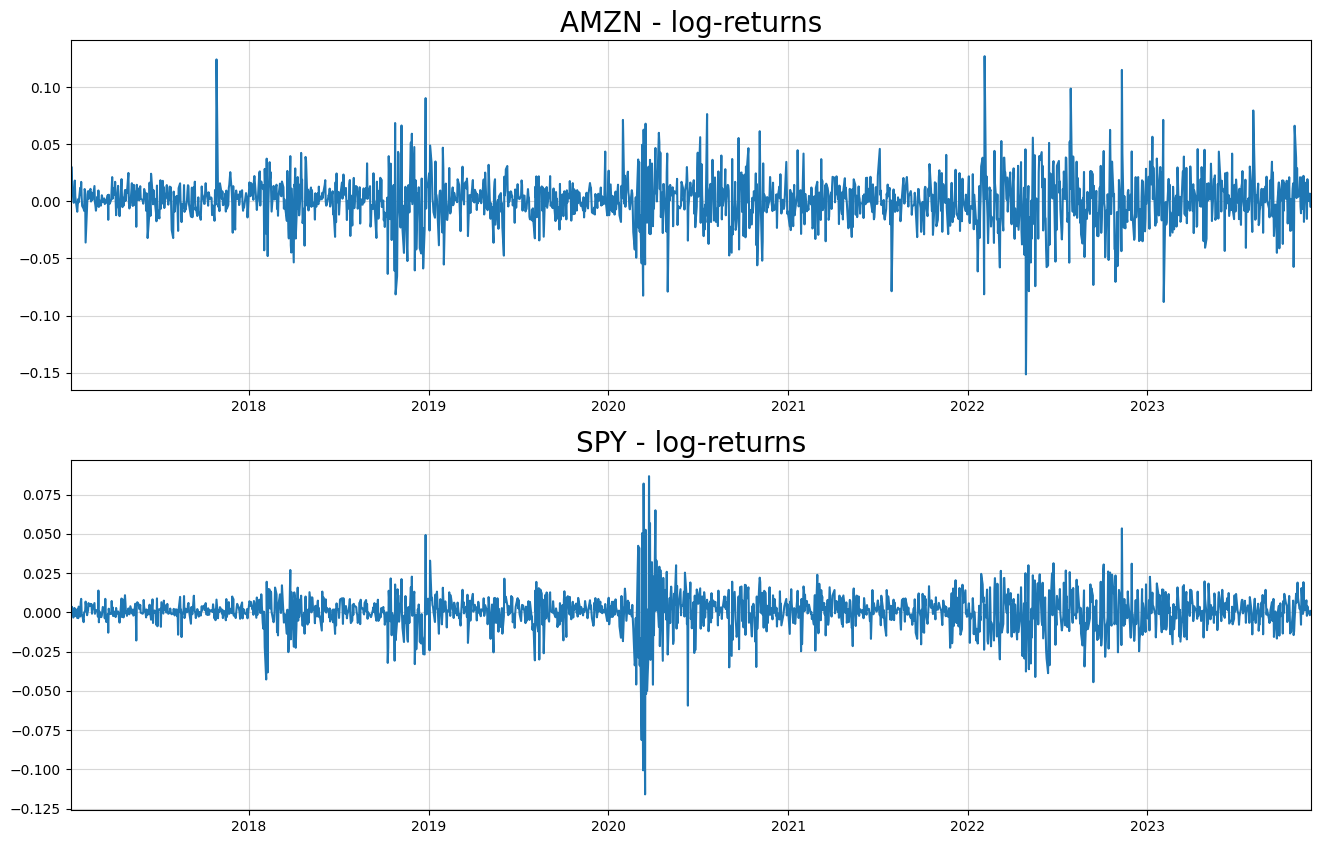

In [3]:
import yfinance as yf
data = yf.download("AMZN SPY", start="2017-01-01", end="2023-11-30", interval="1d")

close = data["Close"]
returns = np.log(close).diff().dropna()


fig, axs = plt.subplots(2,1, figsize = (16,5*2))

for i in range(2):
    axs[i].plot(returns.iloc[:,i])
    axs[i].grid(alpha=0.5)
    axs[i].margins(x=0)
    axs[i].set_title("{} - log-returns".format(returns.columns[i]),size=20)

In [ ]:
# Define the stock symbols
stocks = ["GOOG", "AMZN", "JPM", "GME", "XOM", "SPY"]

# Define the start and end dates for the historical data
start_date = "2000-01-01"  # Replace with your start date
end_date = "2023-11-30"    # Replace with your end date

# Download historical data for each stock
for stock in stocks:
    data = yf.download(stock, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [30]:
returns.ewm(span=40, adjust=False).mean()

,AMZN,SPY
Date,,
2017-01-04,0.004646,0.005932
2017-01-05,0.005896,0.005603
2017-01-06,0.006571,0.005504
2017-01-09,0.006307,0.005075
2017-01-10,0.005937,0.004827
...,...,...
2023-11-22,0.003536,0.002033
2023-11-24,0.003373,0.001963
2023-11-27,0.003537,0.001780


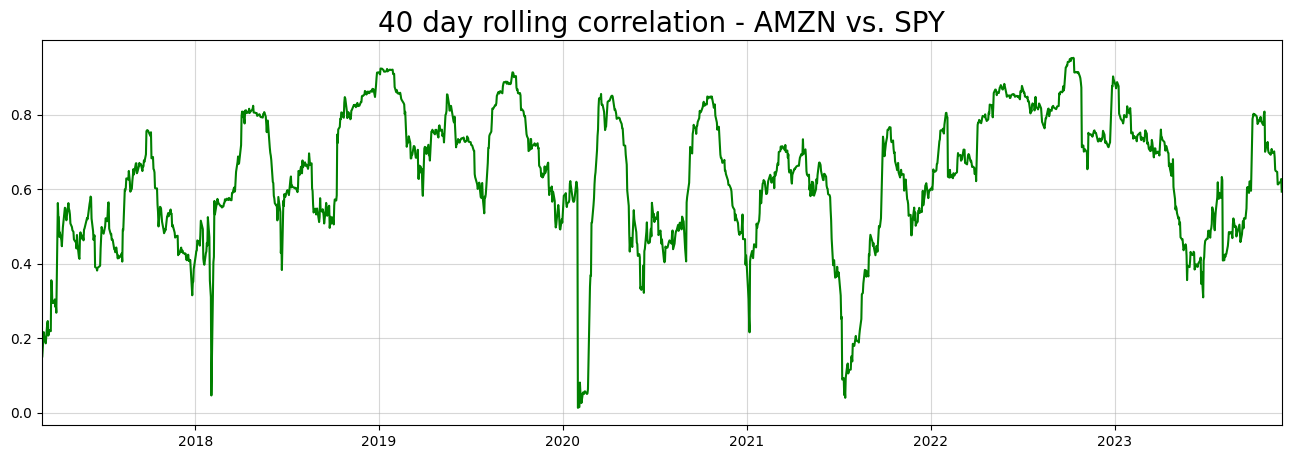

In [31]:
rolling_corrs = returns.rolling(40).corr()
google_spy_rollcorr = rolling_corrs["AMZN"][rolling_corrs.index.get_level_values(1)=="SPY"]

plt.figure(figsize = (16,5))

plt.title("40 day rolling correlation - AMZN vs. SPY",size=20)
plt.plot(returns.index[30:],google_spy_rollcorr.values[30:],c="green", label="40 day rolling correlation")
plt.grid(alpha=0.5)
plt.margins(x=0)

In [32]:
class MGARCH_DCC(tf.keras.Model):
    """
    Tensorflow/Keras implementation of multivariate GARCH under dynamic conditional correlation (DCC) specification.
    Further reading:
        - Engle, Robert. "Dynamic conditional correlation: A simple class of multivariate generalized autoregressive conditional heteroskedasticity models."
        - Bollerslev, Tim. "Modeling the Coherence in Short-Run Nominal Exchange Rates: A Multi-variate Generalized ARCH Model."
        - Lütkepohl, Helmut. "New introduction to multiple time series analysis."
    """

    def __init__(self, y):
        """
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        super().__init__()
        n_dims = y.shape[1]
        self.n_dims = n_dims

        self.MU = tf.Variable(np.mean(y,0)) #use a mean variable

        self.sigma0 = tf.Variable(np.std(y,0)) #initial standard deviations at t=0

        #we initialize all restricted parameters to lie inside the desired range
        #by keeping the learning rate low, this should result in admissible results
        #for more complex models, this might not suffice
        self.alpha0 = tf.Variable(np.std(y,0))
        self.alpha = tf.Variable(tf.zeros(shape=(n_dims,))+0.25)
        self.beta = tf.Variable(tf.zeros(shape=(n_dims,))+0.25)

        self.L0 = tf.Variable(np.float32(np.linalg.cholesky(np.corrcoef(y.T)))) #decomposition of A_0
        self.A = tf.Variable(tf.zeros(shape=(1,))+0.9)
        self.B = tf.Variable(tf.zeros(shape=(1,))+0.05)


    def call(self, y):
        """
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        return self.get_conditional_dists(y)


    def get_log_probs(self, y):
        """
        Calculate log probabilities for a given matrix of time-series observations
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        return self.get_conditional_dists(y).log_prob(y)


    @tf.function
    def get_conditional_dists(self, y):
        """
        Calculate conditional distributions for given observations
        Args:
            y: NxM numpy.array of N observations of M correlated time-series
        """
        T = tf.shape(y)[0]

        #create containers for looping
        mus = tf.TensorArray(tf.float32, size = T) #observation mean container
        Sigmas = tf.TensorArray(tf.float32, size = T) #observation covariance container


        sigmas = tf.TensorArray(tf.float32, size = T+1)
        us = tf.TensorArray(tf.float32, size = T+1)
        Qs = tf.TensorArray(tf.float32, size = T+1)


        #initialize respective values for t=0
        sigmas = sigmas.write(0, self.sigma0)
        A0 = tf.transpose(self.L0)@self.L0
        Qs = Qs.write(0, A0) #set initial unnormalized correlation equal to mean matrix
        us = us.write(0, tf.zeros(shape=(self.n_dims,))) #initial observations equal to zero


        #convenience
        sigma0 = self.sigma0
        alpha0 = self.alpha0**2 #ensure positivity
        alpha = self.alpha
        beta = self.beta

        A = self.A
        B = self.B


        for t in tf.range(T):
            #tm1 = 't minus 1'
            #suppress conditioning on past in notation

            #1) calculate conditional standard deviations
            u_tm1 = us.read(t)
            sigma_tm1 = sigmas.read(t)

            sigma_t = (alpha0 + alpha*sigma_tm1**2 + beta*u_tm1**2)**0.5

            #2) calculate conditional correlations
            u_tm1_standardized = u_tm1/sigma_tm1

            Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

            Q_tm1 = Qs.read(t)
            Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
            R_t = self.cov_to_corr(Q_t)

            #3) calculate conditional covariance
            D_t = tf.linalg.LinearOperatorDiag(sigma_t)
            Sigma_t = D_t@R_t@D_t


            #4) store values for next iteration
            sigmas = sigmas.write(t+1, sigma_t)
            us = us.write(t+1, y[t,:]-self.MU) #we want to model the zero-mean disturbances
            Qs = Qs.write(t+1, Q_t)

            mus = mus.write(t, self.MU)
            Sigmas = Sigmas.write(t, Sigma_t)

        return tfp.distributions.MultivariateNormalFullCovariance(mus.stack(), Sigmas.stack())


    def cov_to_corr(self, S):
        """
        Transforms covariance matrix to a correlation matrix via matrix operations
        Args:
            S: Symmetric, positive semidefinite covariance matrix (tf.Tensor)
        """
        D = tf.linalg.LinearOperatorDiag(1/(tf.linalg.diag_part(S)**0.5))
        return D@S@D



    def train_step(self, data):
        """
        Custom training step to handle keras model.fit given that there is no input-output structure in our model
        Args:
            S: Symmetric, positive semidefinite covariance matrix (tf.Tensor)
        """
        x,y = data
        with tf.GradientTape() as tape:
            loss = -tf.math.reduce_mean(self.get_log_probs(y))

        trainable_vars = self.trainable_weights
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"Current loss": loss}



    def sample_forecast(self, y, T_forecast = 30, n_samples=500):
        """
        Create forecast samples to use for monte-carlo simulation of quantities of interest about the forecast (e.g. mean, var, corr, etc.)
        WARNING: This is not optimized very much and can take some time to run, probably due to Python's slow loops - can likely be improved
        Args:
            y: numpy.array of training data, used to initialize the forecast values
            T_forecast: number of periods to predict (integer)
            n_samples: Number of samples to draw (integer)
        """
        T = tf.shape(y)[0]

        #create lists for looping; no gradients, thus no tf.TensorArrays needed
        #can initialize directly
        mus = []
        Sigmas = []

        us = [tf.zeros(shape=(self.n_dims,))]
        sigmas = [self.sigma0]
        Qs = []

        #initialize remaining values for t=0
        A0 = tf.transpose(self.L0)@self.L0
        Qs.append(A0)


        #convenience
        sigma0 = self.sigma0
        alpha0 = self.alpha0**2 #ensure positivity
        alpha = self.alpha
        beta = self.beta

        A = self.A
        B = self.B

        #'warmup' to initialize latest lagged features
        for t in range(T):
            #tm1 = 't minus 1'
            #suppress conditioning on past in notation
            u_tm1 = us[-1]
            sigma_tm1 = sigmas[-1]

            sigma_t = (alpha0 + alpha*sigma_tm1**2 + beta*u_tm1**2)**0.5

            u_tm1_standardized = u_tm1/sigma_tm1

            Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

            Q_tm1 = Qs[-1]
            Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
            R_t = self.cov_to_corr(Q_t)

            D_t = tf.linalg.LinearOperatorDiag(sigma_t)
            Sigma_t = D_t@R_t@D_t


            sigmas.append(sigma_t)
            us.append(y[t,:]-self.MU) #we want to model the zero-mean disturbances
            Qs.append(Q_t)

            mus.append(self.MU)
            Sigmas.append(Sigma_t)


        #sample containers
        y_samples = []
        R_samples = []
        sigma_samples = []


        for n in range(n_samples):

            mus_samp = []
            Sigmas_samp = []

            sigmas_samp = [sigmas[-1]]
            us_samp = [us[-1]]
            Qs_samp = [Qs[-1]]

            #forecast containers
            ys_samp = []
            sig_samp = []
            R_samp = []


            for t in range(T_forecast):
                u_tm1 = us_samp[-1]
                sigma_tm1 = sigmas_samp[-1]

                sigma_t = (alpha0 + alpha**2 + beta*u_tm1**2)**0.5

                u_tm1_standardized = u_tm1/sigma_tm1

                Psi_tilde_tm1 = tf.reshape(u_tm1_standardized, (self.n_dims,1))@tf.reshape(u_tm1_standardized, (1,self.n_dims))

                Q_tm1 = Qs_samp[-1]
                Q_t = A0 + A*(Q_tm1 - A0) + B*(Psi_tilde_tm1 - A0)
                R_t = self.cov_to_corr(Q_t)

                D_t = tf.linalg.LinearOperatorDiag(sigma_t)
                Sigma_t = D_t@R_t@D_t


                sigmas_samp.append(sigma_t)
                Qs_samp.append(Q_t)

                ynext = tfp.distributions.MultivariateNormalFullCovariance(self.MU, Sigma_t).sample()
                ys_samp.append(tf.reshape(ynext,(1,1,-1)))
                sig_samp.append(tf.reshape(sigma_t,(1,1,-1)))
                R_samp.append(tf.reshape(R_t,(1,1,self.n_dims,self.n_dims)))

                us_samp.append(ynext-self.MU)

            y_samples.append(tf.concat(ys_samp,1))
            R_samples.append(tf.concat(R_samp,1))
            sigma_samples.append(tf.concat(sig_samp,1))

        return tf.concat(y_samples,0).numpy(), tf.concat(R_samples,0).numpy(), tf.concat(sigma_samples,0).numpy()

In [33]:
train = np.float32(returns)[:-90,:]
test = np.float32(returns)[-90:,:]

<Figure size 1600x600 with 0 Axes>

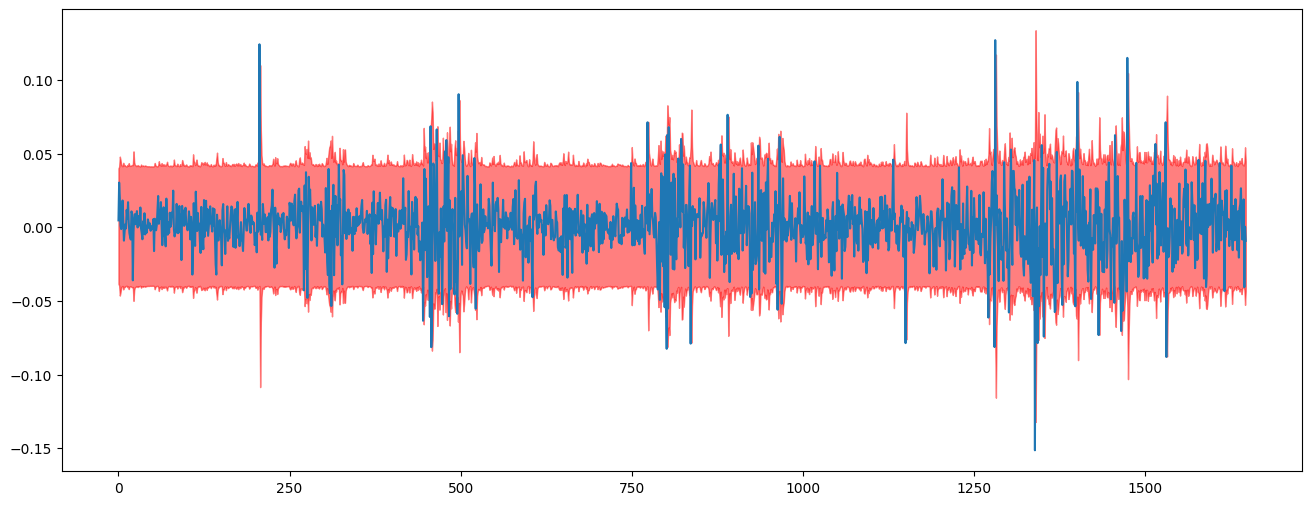

In [34]:
model = MGARCH_DCC(train)


from scipy.stats import norm
out = model(train)

means = out.mean().numpy()
stds = out.stddev().numpy()

lowers = norm(means, stds).ppf(0.05)
uppers = norm(means, stds).ppf(0.95)

plt.figure(figsize = (16,6))

i = 0

plt.figure(figsize = (16,6))
plt.plot(train[:,i])
plt.fill_between(np.arange(len(train)),lowers[:,i],uppers[:,i],color="red",alpha=0.5)


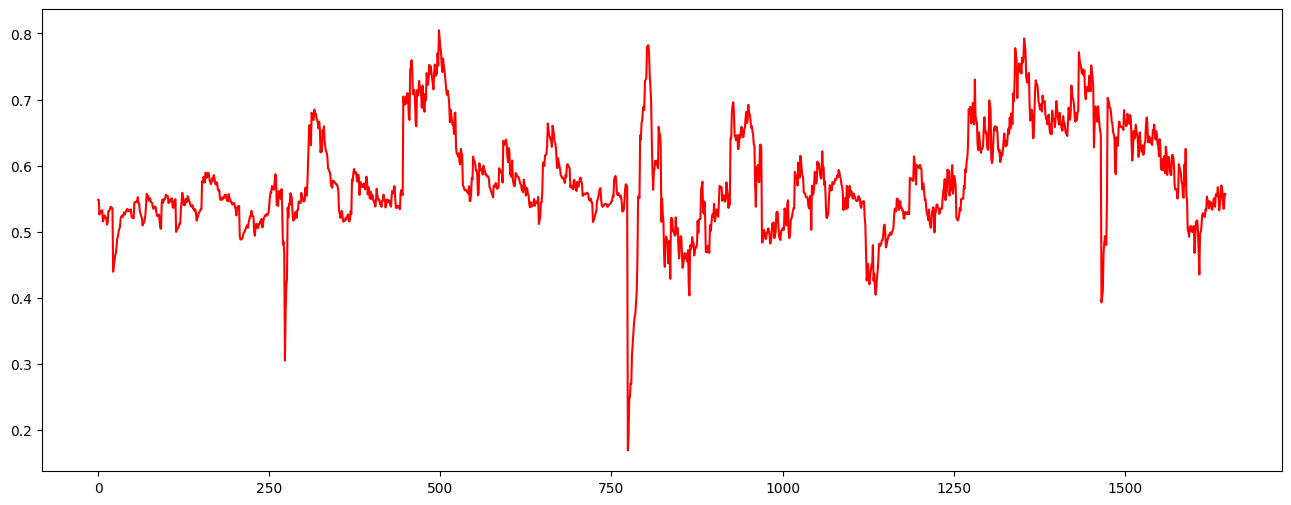

In [35]:
plt.figure(figsize = (16,6))

corr12 = [model.cov_to_corr(out.covariance()[i,:,:])[0,1].numpy() for i in range(len(train))]
plt.plot(corr12,c="red")

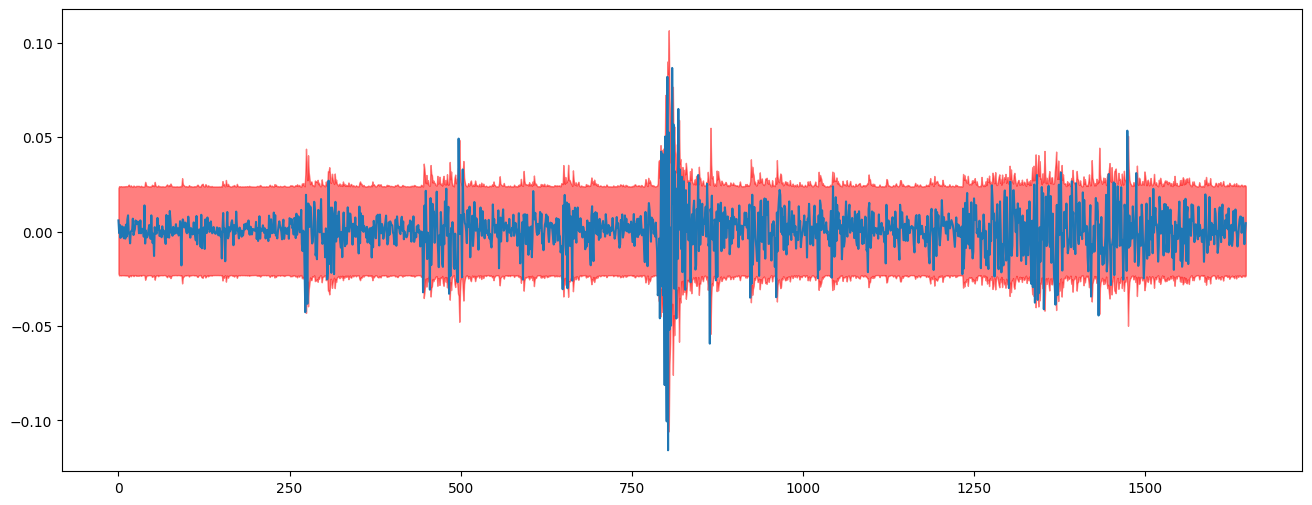

In [36]:
i = 1

plt.figure(figsize = (16,6))
plt.plot(train[:,i])
plt.fill_between(np.arange(len(train)),lowers[:,i],uppers[:,i],color="red",alpha=0.5)

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [38]:
model.fit(train, train, batch_size=len(train), shuffle=False, epochs = 300, verbose=False)


In [39]:
out = model(train)

means = out.mean().numpy()
stds = out.stddev().numpy()

lowers = norm(means, stds).ppf(0.05)
uppers = norm(means, stds).ppf(0.95)

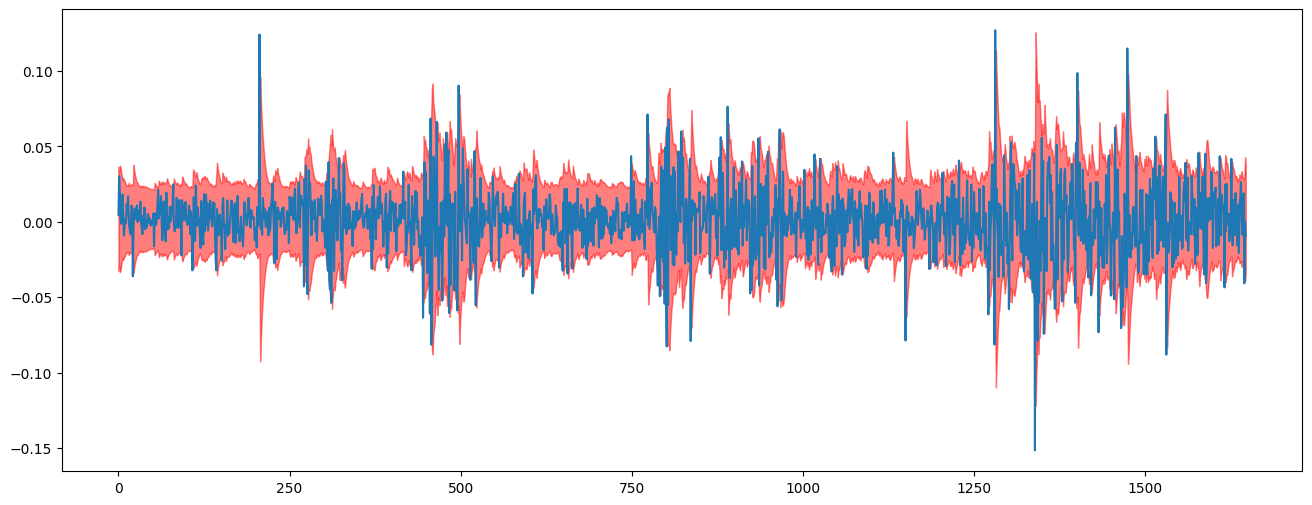

In [42]:
i = 0

plt.figure(figsize = (16,6))
plt.plot(train[:,i])
plt.fill_between(np.arange(len(train)),lowers[:,i],uppers[:,i],color="red",alpha=0.5)

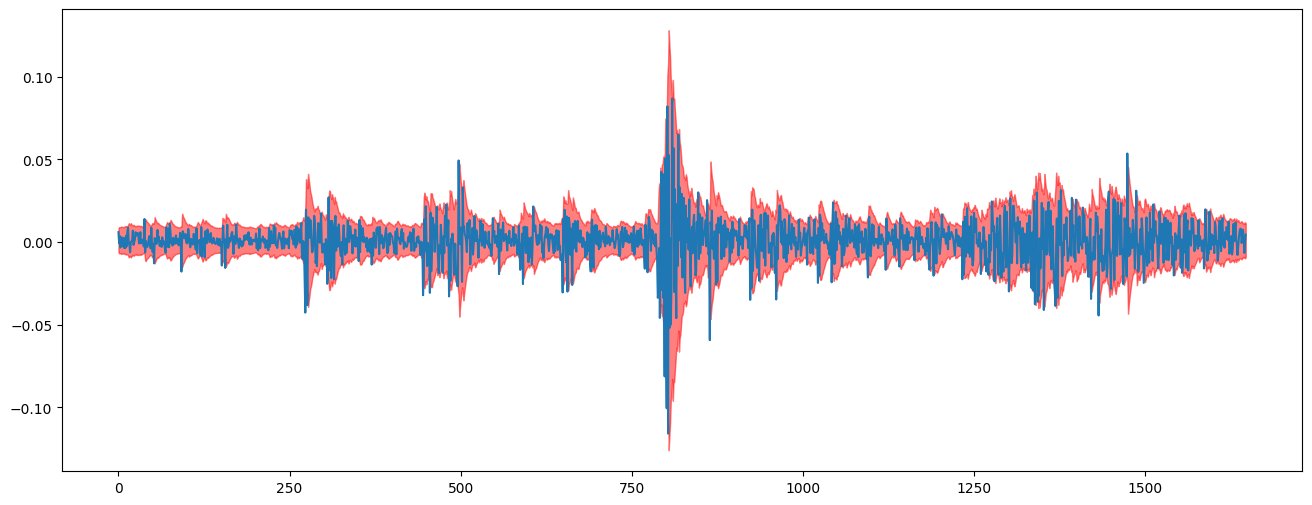

In [43]:
i = 1

plt.figure(figsize = (16,6))
plt.plot(train[:,i])
plt.fill_between(np.arange(len(train)),lowers[:,i],uppers[:,i],color="red",alpha=0.5)

In [44]:
corr12 = [model.cov_to_corr(out.covariance()[i,:,:])[0,1].numpy() for i in range(len(train))]


In [45]:
np.random.seed(123)
tf.random.set_seed(123)

fcast = model.sample_forecast(train,90,1000)

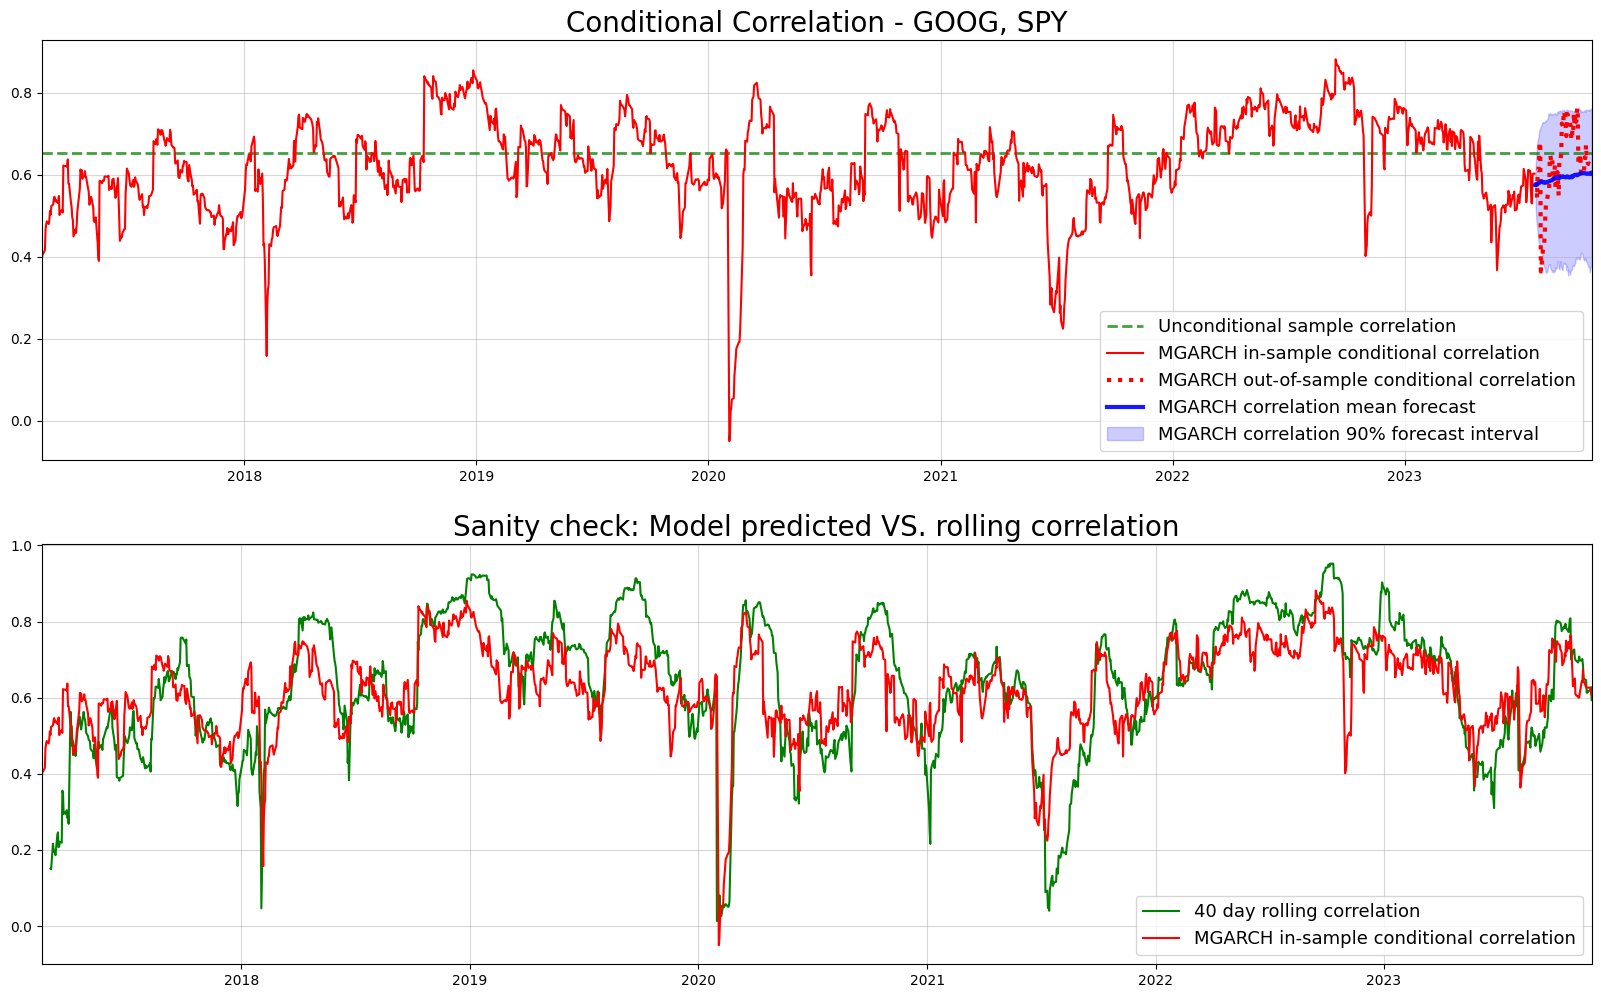

In [46]:
corrs = fcast[1][:,:,0,1]
corr_means = np.mean(corrs,0)
corr_lowers = np.quantile(corrs,0.05,0)
corr_uppers = np.quantile(corrs,0.95,0)


conditional_dists = model(np.float32(returns.values))

conditional_correlations = [model.cov_to_corr(conditional_dists.covariance()[i,:,:])[0,1].numpy() for i in range(len(returns))]


idx_train = returns[:-90].index
idx_test = pd.date_range(returns[:-90].index[-1] + timedelta(days=1), returns[:-90].index[-1] + timedelta(days=90))

fig, axs = plt.subplots(2,1,figsize=(20,12), gridspec_kw={'height_ratios': [1, 1]})

axs[0].set_title("Conditional Correlation - GOOG, SPY", size=20)

axs[0].axhline(np.corrcoef(returns.T)[0,1], c="green",alpha=0.75,ls="dashed",lw=2, label="Unconditional sample correlation")

axs[0].plot(idx_train[30:],conditional_correlations[30:-90],c="red", label="MGARCH in-sample conditional correlation")
axs[0].plot(idx_test,conditional_correlations[-90:],c="red",ls="dotted",lw=3, label="MGARCH out-of-sample conditional correlation")

axs[0].plot(idx_test, corr_means,color="blue",lw=3, alpha=0.9, label="MGARCH correlation mean forecast")
axs[0].fill_between(idx_test, corr_lowers, corr_uppers, color="blue", alpha=0.2, label="MGARCH correlation 90% forecast interval")

axs[0].grid(alpha=0.5)
axs[0].legend(prop = {"size":13})
axs[0].margins(x=0)


axs[1].set_title("Sanity check: Model predicted VS. rolling correlation",size=20)
axs[1].plot(returns.index[30:],google_spy_rollcorr.values[30:],c="green", label="40 day rolling correlation")
axs[1].plot(returns.index[30:],conditional_correlations[30:],c="red", label="MGARCH in-sample conditional correlation")
axs[1].grid(alpha=0.5)
axs[1].legend(prop = {"size":13})
axs[1].margins(x=0)

In [ ]:
len(google_spy_rollcorr)

4853

In [ ]:
rolling_corrs = returns.rolling(40,min_periods=0).corr()
google_spy_rollcorr = rolling_corrs["GOOG"][rolling_corrs.index.get_level_values(1)=="SPY"]


In [ ]:
label = returns.rolling(40).corr()["GOOG"][rolling_corrs.index.get_level_values(1)=="SPY"].droplevel(1).shift(-40).dropna()


In [ ]:
label

Date
2017-01-04    0.590896
2017-01-05    0.614598
2017-01-06    0.592853
2017-01-09    0.586793
2017-01-10    0.584865
                ...   
2023-09-27    0.664385
2023-09-28    0.659970
2023-09-29    0.657649
2023-10-02    0.676084
2023-10-03    0.675088
Name: GOOG, Length: 1698, dtype: float64

In [ ]:
data

Adj Close                   Close                    High  \
                  GOOG         SPY        GOOG         SPY        GOOG   
Date                                                                     
2017-01-03   39.306999  200.629684   39.306999  225.240005   39.481499   
2017-01-04   39.345001  201.823257   39.345001  226.580002   39.567001   
2017-01-05   39.701000  201.662933   39.701000  226.399994   39.723999   
2017-01-06   40.307499  202.384445   40.307499  227.210007   40.395000   
2017-01-09   40.332500  201.716400   40.332500  226.460007   40.498299   
...                ...         ...         ...         ...         ...   
2023-11-22  140.020004  455.019989  140.020004  455.019989  141.100006   
2023-11-24  138.220001  455.299988  138.220001  455.299988  139.677002   
2023-11-27  138.050003  454.480011  138.050003  454.480011  139.630005   
2023-11-28  138.619995  454.929993  138.619995  454.929993  138.660004   
2023-11-29  136.399994  454.609985  136.399994  454.609985  139.669998   

                               Low                    Open              \
                   SPY        GOOG         SPY        GOOG         SPY   
Date                                                                     
2017-01-03  225.830002   38.790001  223.880005   38.940498  225.039993   
2017-01-04  226.750000   39.158001  225.610001   39.417999  225.619995   
2017-01-05  226.580002   39.250999  225.479996   39.304001  226.270004   
2017-01-06  227.750000   39.610199  225.899994   39.763000  226.529999   
2017-01-09  227.070007   40.141499  226.419998   40.320000  226.910004   
...                ...         ...         ...         ...         ...   
2023-11-22  456.380005  139.000000  453.890015  139.100006  454.980011   
2023-11-24  455.500000  137.470001  454.730011  139.539993  455.070007   
2023-11-27  455.489990  137.539993  454.079987  137.570007  454.649994   
2023-11-28  456.269989  137.039993  453.500000  137.630005  454.079987   
2023-11-29  458.320007  136.294998  454.200012  138.985001  457.149994   

              Volume            
                GOOG       SPY  
Date                            
2017-01-03  33146000  91366500  
2017-01-04  21460000  78744400  
2017-01-05  26704000  78379000  
2017-01-06  32804000  71559900  
2017-01-09  25492000  46939700  
...              ...       ...  
2023-11-22  17306400  59394900  
2023-11-24   8828600  29737400  
2023-11-27  17886400  50506000  
2023-11-28  17046900  62115000  
2023-11-29  21014700  63146000  

[1739 rows x 12 columns]

In [4]:
import yfinance as yf
data = yf.download("GOOG SPY", start="2017-01-01", end="2023-11-30", interval="1d")

close = data["Close"]
returns = np.log(close).diff().dropna()



[*********************100%%**********************]  2 of 2 completed


In [8]:
rolling_corrs = returns.rolling(40).corr()
google_spy_rollcorr = rolling_corrs["GOOG"][rolling_corrs.index.get_level_values(1)=="SPY"]


In [9]:
correlations = google_spy_rollcorr.dropna().droplevel(1)

correlations_stride = []

for i in range(-800,0,40):
  correlations_stride.append(correlations[i])



In [16]:

model = auto_arima(correlations, seasonal=False, stepwise=True)
residuals = model.resid()

forecast, conf_int = model.predict(n_periods=1, return_conf_int=True)


In [15]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import xgboost as xgb
from pandas import DataFrame
import matplotlib.pyplot as plt
from scipy import stats
import math
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.linear_model import Lasso
from keras.models import Sequential
from keras import layers
import keras
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, Embedding, Input, Masking, GlobalAveragePooling1D
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import scipy.optimize as sco

In [17]:
residuals.values

array([ 0.57978178,  0.01111399,  0.02370218, ..., -0.00232133,
        0.01843532, -0.00099603])

In [22]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Example data (replace this with your 'residual' data)
data = residuals.values

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, n_steps):
    X, Y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        Y.append(data[i + n_steps])
    return np.array(X), np.array(Y)

n_steps = 60  # Number of time steps (modify as needed)
X, Y = create_sequences(data_normalized, n_steps)

# Reshaping X for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)  # [samples, time steps, features]

# X and Y are now ready to be fed into an LSTM model


In [23]:

def LSTM_model():

    model = Sequential()

    model.add(LSTM(units = 100, return_sequences = True, input_shape=(n_steps, 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 100))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5',
                               verbose = 2,
                               save_best_only = True)

# model.fit(X,
#           Y,
#           epochs=10,
#           batch_size = 128,
#           callbacks = [checkpointer])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = Y[:train_size], Y[train_size:]


In [ ]:
actual = []
prediction = []
for i in range(len(X_val)):
    # 更新训练集和验证集
    X_train_step = np.concatenate((X_train, X_val[:i]), axis=0)
    y_train_step = np.concatenate((y_train, y_val[:i]), axis=0)

    # 重新训练模型
    model.fit(X_train_step, y_train_step, epochs=5, verbose=1)

    # 预测并与真实值比较
    X_val_step = X_val[i].reshape(1, n_steps, 1)
    y_val_pred = model.predict(X_val_step)
    print(f"Predicted: {y_val_pred}, Actual: {y_val[i]}")
    prediction.append(y_val_pred)
    actual.append(y_val[i])

Epoch 1/5
41/41 [==============================] - 5s 112ms/step - loss: 0.0014
Epoch 2/5
41/41 [==============================] - 4s 92ms/step - loss: 0.0014
Epoch 3/5
41/41 [==============================] - 5s 129ms/step - loss: 0.0014
Epoch 4/5
41/41 [==============================] - 4s 100ms/step - loss: 0.0013
Epoch 5/5
1/1 [==============================] - 1s 812ms/step
Predicted: [[0.296543]], Actual: [0.29199297]
Epoch 1/5
41/41 [==============================] - 5s 116ms/step - loss: 0.0014
Epoch 2/5
41/41 [==============================] - 4s 101ms/step - loss: 0.0014
Epoch 3/5
41/41 [==============================] - 6s 151ms/step - loss: 0.0013
Epoch 4/5
41/41 [==============================] - 4s 91ms/step - loss: 0.0013
Epoch 5/5
1/1 [==============================] - 0s 33ms/step
Predicted: [[0.29427755]], Actual: [0.28881086]
Epoch 1/5
42/42 [==============================] - 5s 124ms/step - loss: 0.0013
Epoch 2/5
42/42 [==============================] - 4s 92ms/step

In [84]:
from tensorflow.keras.models import load_model


# Load the LSTM model
model_lstm = load_model('epoch247.h5')

# Reshape data for LSTM (assuming it expects [samples, timesteps, features])
lstm_data = np.array(residuals).reshape(1, -1, 1)


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import pylab as pl
from pmdarima import ARIMA, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.simplefilter("ignore")

In [99]:
lstm_prediction = model_lstm.predict(lstm_data)


1/1 [==============================] - 0s 25ms/step


In [100]:
final_prediction = forecast + lstm_prediction[0, 0]
final_prediction = min(max(final_prediction, -1), 1)  # Ensure it's within [-1, 1]


In [101]:
lstm_prediction

array([[0.54218]], dtype=float32)

In [89]:
forecast

array([0.75835236])

In [90]:
lstm_prediction[0, 0]

0.54218

In [91]:
final_prediction

1

In [92]:
correlations_stride

[0.7974539384678823,
 0.7427191094362213,
 0.7463458758874468,
 0.6389977960407788,
 0.6980222066218326,
 0.643197678093887,
 0.7314726310430583,
 0.6193071781768441,
 0.8854469022610194,
 0.7875013534273861,
 0.882574666790758,
 0.8940211655591244,
 0.8377776937330659,
 0.92814452875141,
 0.7768908394378324,
 0.7105737501541779,
 0.6533922969965446,
 0.44706930006354106,
 0.5123936165587022,
 0.7770377500128998]

In [94]:
residuals

array([ 0.05734606, -0.02571946,  0.00494797, -0.10419184,  0.00786578,
       -0.0761186 ,  0.03924134, -0.11653462,  0.20501824, -0.02440842,
        0.11905297,  0.08353036,  0.02163197,  0.13978479, -0.05611286,
       -0.04770603, -0.07212482, -0.25019844, -0.08294429,  0.14942764])

In [95]:
lstm_data

array([[[ 0.05734606],
        [-0.02571946],
        [ 0.00494797],
        [-0.10419184],
        [ 0.00786578],
        [-0.0761186 ],
        [ 0.03924134],
        [-0.11653462],
        [ 0.20501824],
        [-0.02440842],
        [ 0.11905297],
        [ 0.08353036],
        [ 0.02163197],
        [ 0.13978479],
        [-0.05611286],
        [-0.04770603],
        [-0.07212482],
        [-0.25019844],
        [-0.08294429],
        [ 0.14942764]]])